### Importa los datos
Dataset con diferentes fármacos, sus efectos y ratings de los clientes.

Importa el dataset *drugLibTrain_raw.tsv*

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/drugLibTrain_raw.tsv', sep='\t', index_col=0)

### Descriptive Analysis

Quedate únicamente con las columnas que podamos manejar: Columnas numéricas y columnas categoricas con pocas categorias (menos de 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 2202 to 2748
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        3107 non-null   object
 1   rating             3107 non-null   int64 
 2   effectiveness      3107 non-null   object
 3   sideEffects        3107 non-null   object
 4   condition          3106 non-null   object
 5   benefitsReview     3089 non-null   object
 6   sideEffectsReview  3032 non-null   object
 7   commentsReview     3095 non-null   object
dtypes: int64(1), object(7)
memory usage: 218.5+ KB


In [5]:
df.describe()

,rating
count,3107.000000
mean,7.006115
std,2.937582
min,1.000000
25%,5.000000
50%,8.000000
75%,9.000000
max,10.000000


In [6]:
df.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [7]:
uniques = {}
for col in df.select_dtypes(include=['object']).columns:
    uniques[col] = len(df[col].unique())

uniques = pd.DataFrame.from_dict(uniques, orient="index", columns=["n_unique"])
uniques

,n_unique
urlDrugName,502
effectiveness,5
sideEffects,5
condition,1427
benefitsReview,3032
sideEffectsReview,2814
commentsReview,3047


In [8]:
df = df[["rating", "effectiveness", "sideEffects"]]
df.head()

,rating,effectiveness,sideEffects
2202,4,Highly Effective,Mild Side Effects
3117,1,Highly Effective,Severe Side Effects
1146,10,Highly Effective,No Side Effects
3947,3,Marginally Effective,Mild Side Effects
1951,2,Marginally Effective,Severe Side Effects


#### Transforma las columnas categoricas

Transforma las columnas categoricas a numericas mediante dummies

In [9]:
df = pd.merge(df["rating"], pd.get_dummies(df[["effectiveness", "sideEffects"]], drop_first=True).astype(int), left_index=True, right_index=True)

In [10]:
my_dict = {"Ineffective":0,
            "Marginally Effective":1,
            "Moderately Effective":2,
            "Considerably Effective":3,
            "Highly Effective":4}

In [11]:
my_dict = {"No Side Effects":0,
            "Mild Side Effects":1,
            "Moderate Side Effects":2,
            "Severe Side Effects":3,
            "Extremely Severe Side Effects":4}

#### Evalua cual es la mejor K

Utiliza silhouette_score para evaluar cual es la mejor K. Evalua como mucho K = 20

#### Genera el K Means 

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

Mayor silhouette scores con K=2

In [13]:
km = KMeans(n_clusters=2)
km.fit(df)
silhouette_score(df, km.labels_)

/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.6201588218717601

Con el Elbow method comprobamos que k=2 sería la opción más adecuada

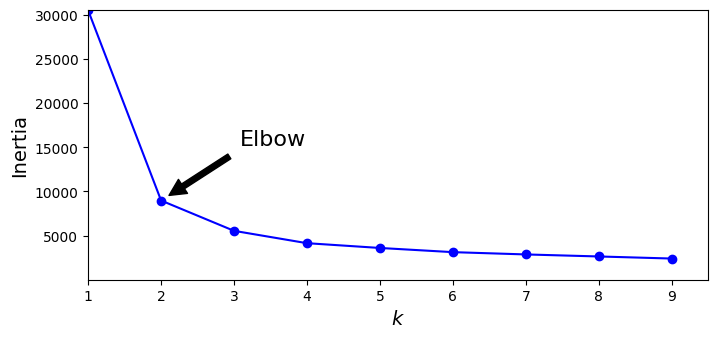

In [35]:


kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

df_kmeans = pd.DataFrame(inertias, columns=['inertia'])
df_kmeans['inertia_1'] = df_kmeans['inertia'].shift(1)
df_kmeans['diff%'] = df_kmeans['inertia']/df_kmeans['inertia_1']
df_kmeans

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-");
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
              xy=(2, inertias[1]),
              xytext=(0.30, 0.55),
              textcoords='figure fraction',
              fontsize=16,
              arrowprops=dict(facecolor='black', shrink=0.1)
             )
plt.axis([1, 9.5, 10, 30500])
plt.show()

#### Muestra en un gráfico de tartas la distribución de los distintos clusters

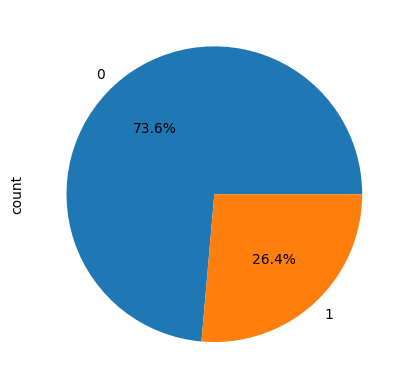

In [60]:
y_pred = km.fit_predict(df)
df_clusters = pd.DataFrame(y_pred, columns=['Cluster'])
df_clusters['Cluster'].value_counts().plot.pie(autopct="%.1f%%")